# Imports

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from IPython import display

# Parameters

In [2]:
# Define global constants
BATCH_SIZE = 128
LATENT_DIM = 2

# Prepare the Dataset

In [3]:
def map_image(image,label):
  image = tf.cast(image,tf.float32)
  image = image / 255.0
  image = tf.reshape(image,shape = (28,28,1,))
  return image

def get_dataset(map_fn,is_validation = False):
  if is_validation:
    split_name = 'test'
  else:
    split_name = 'train'

  dataset = tfds.load('mnist',as_supervised = True,split = split_name)
  dataset = dataset.map(map_fn)

  if is_validation:
    dataset = dataset.batch(BATCH_SIZE)
  else:
    dataset = dataset.shuffle(1024).batch(BATCH_SIZE)

  return dataset

In [4]:
train_dataset = get_dataset(map_image)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


# Build the Model

<img src="https://drive.google.com/uc?export=view&id=1YAZAeMGEJ1KgieYk1ju-S9DoshpMREeC" width="60%" height="60%"/>

### Sampling Class

In [5]:
class Sampling(tf.keras.layers.Layer):
  def call(self,inputs):
    # Unpack the output of the encoder
    mu,sigma = inputs

    # Get the size and dimensions of the batch
    batch = tf.shape(mu)[0]
    dim = tf.shape(mu)[1]

    # Generate a random tensor
    epsilon = tf.keras.backend.random_normal(shape = (batch,dim))

    # Combine the inputs and noise
    return mu + tf.exp(0.5 * sigma) * epsilon

### Encoder

<img src="https://drive.google.com/uc?export=view&id=1eoxFK_UVSHd3a_5EHcCU8F8QDZlPiXfW" width="60%" height="60%"/>

In [6]:
def encoder_layer(inputs, latent_dim):

  # add the Conv2D layers followed by BatchNormalization
  x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding="same", activation='relu', name="encode_conv1")(inputs)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu', name="encode_conv2")(x)

  # assign to a different variable so you can extract the shape later
  batch_2 = tf.keras.layers.BatchNormalization()(x)

  # flatten the features and feed into the Dense network
  x = tf.keras.layers.Flatten(name="encode_flatten")(batch_2)

  x = tf.keras.layers.Dense(20, activation='relu', name="encode_dense")(x)
  x = tf.keras.layers.BatchNormalization()(x)

  # add output Dense networks for mu and sigma, units equal to the declared latent_dim.
  mu = tf.keras.layers.Dense(latent_dim, name='latent_mu')(x)
  sigma = tf.keras.layers.Dense(latent_dim, name ='latent_sigma')(x)

  return mu, sigma, batch_2.shape

In [7]:
def encoder_model(latent_dim, input_shape):

  # declare the inputs tensor with the given shape
  inputs = tf.keras.layers.Input(shape=input_shape)

  # get the output of the encoder_layers() function
  mu, sigma, conv_shape = encoder_layer(inputs, latent_dim=LATENT_DIM)

  # feed mu and sigma to the Sampling layer
  z = Sampling()((mu, sigma))

  # build the whole encoder model
  model = tf.keras.Model(inputs, outputs=[mu, sigma, z])

  return model, conv_shape

### Decoder

In [14]:
def decoder_layer(inputs, conv_shape):

  # feed to a Dense network with units computed from the conv_shape dimensions
  units = conv_shape[1] * conv_shape[2] * conv_shape[3]
  x = tf.keras.layers.Dense(units, activation = 'relu', name="decode_dense1")(inputs)
  x = tf.keras.layers.BatchNormalization()(x)

  # reshape output using the conv_shape dimensions
  x = tf.keras.layers.Reshape((conv_shape[1], conv_shape[2], conv_shape[3]), name="decode_reshape")(x)

  # upsample the features back to the original dimensions
  x = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu', name="decode_conv2d_2")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu', name="decode_conv2d_3")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  # Strides = 1
  x = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same', activation='sigmoid', name="decode_final")(x)

  return x

In [15]:
def decoder_model(latent_dim, conv_shape):

  # set the inputs to the shape of the latent space
  inputs = tf.keras.layers.Input(shape=(latent_dim,))

  # get the output of the decoder layers
  outputs = decoder_layer(inputs, conv_shape)

  # declare the inputs and outputs of the model
  model = tf.keras.Model(inputs, outputs)

  return model

# Kullback-Leibler Divergence

In [16]:
def kl_reconstruction_loss(mu,sigma):
  kl_loss = 1 + sigma - tf.square(mu) - tf.math.exp(sigma)
  kl_loss = tf.reduce_mean(kl_loss) * -0.5

  return kl_loss

# VAE Model

In [17]:
def vae_model(encoder, decoder, input_shape):
  # set the inputs
  inputs = tf.keras.layers.Input(shape=input_shape)

  # get mu, sigma, and z from the encoder output
  mu, sigma, z = encoder(inputs)

  # get reconstructed output from the decoder
  reconstructed = decoder(z)

  # define the inputs and outputs of the VAE
  model = tf.keras.Model(inputs=inputs, outputs=reconstructed)

  # add the KL loss
  loss = kl_reconstruction_loss(mu, sigma)
  model.add_loss(loss)

  return model

In [18]:
def get_models(input_shape, latent_dim):
  """Returns the encoder, decoder, and vae models"""
  encoder, conv_shape = encoder_model(latent_dim=latent_dim, input_shape=input_shape)
  decoder = decoder_model(latent_dim=latent_dim, conv_shape=conv_shape)
  vae = vae_model(encoder, decoder, input_shape=input_shape)
  return encoder, decoder, vae

In [19]:
# Get the encoder,decoder and 'master' model [VAE]
encoder,decoder,vae = get_models(input_shape = (28,28,1,),latent_dim = LATENT_DIM)

# Train the Model

In [20]:
# Define loss function and optimizers
optimizer = tf.keras.optimizers.Adam()
loss_metric = tf.keras.metrics.Mean()
bce_loss = tf.keras.losses.BinaryCrossentropy()

In [21]:
def generate_and_save_images(model,epoch,step,test_input):
  # Generate iamges from the test input
  predictions = model.predict(test_input)

  # Plot the results
  fig = plt.figure(figsize = (4,4))

  for i in range(predictions.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(predictions[i,:,:,0],cmap = 'gray')
    plt.axis('off')

  # tight_layout minimized the overlap between 2 subplots
  fig.suptitle("epoch: {}, step: {}".format(epoch,step))
  plt.savefig('image_at_epoch_{:04d}_step{:04d}.png'.format(epoch,step))
  plt.show()

1/1 [==============================] - 0s 17ms/step


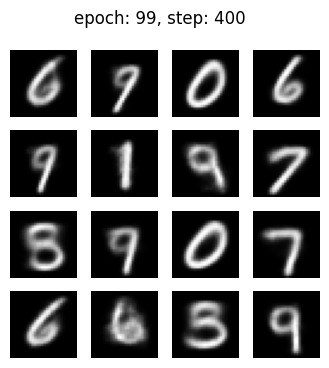

Epoch: 99 step: 400 mean loss = 142.27115


In [22]:
# Training loop.

# generate random vector as test input to the decoder
random_vector_for_generation = tf.random.normal(shape=[16, LATENT_DIM])

# number of epochs
epochs = 100

# initialize the helper function to display outputs from an untrained model
generate_and_save_images(decoder, 0, 0, random_vector_for_generation)

for epoch in range(epochs):
  print('Start of epoch %d' % (epoch,))

  # iterate over the batches of the dataset.
  for step, x_batch_train in enumerate(train_dataset):
    with tf.GradientTape() as tape:

      # feed a batch to the VAE model
      reconstructed = vae(x_batch_train)

      # compute reconstruction loss
      flattened_inputs = tf.reshape(x_batch_train, shape=[-1])
      flattened_outputs = tf.reshape(reconstructed, shape=[-1])
      loss = bce_loss(flattened_inputs, flattened_outputs) * 784

      # add KLD regularization loss
      loss += sum(vae.losses)

    # get the gradients and update the weights
    grads = tape.gradient(loss, vae.trainable_weights)
    optimizer.apply_gradients(zip(grads, vae.trainable_weights))

    # compute the loss metric
    loss_metric(loss)

    # display outputs every 100 steps
    if step % 100 == 0:
      display.clear_output(wait=False)
      generate_and_save_images(decoder, epoch, step, random_vector_for_generation)
      print('Epoch: %s step: %s mean loss = %s' % (epoch, step, loss_metric.result().numpy()))